# Risk Management Dashboard - VaR Modeling

This notebook implements various Value-at-Risk (VaR) methodologies for the risk management dashboard. We'll use the processed data from the previous notebook to calculate and compare different VaR approaches.

## What is Value-at-Risk (VaR)?

Value-at-Risk is a statistical measure that quantifies the level of financial risk within a portfolio over a specific time frame. It estimates how much a portfolio might lose with a given probability over a defined period.

For example, a one-day 95% VaR of $1 million means there is a 5% chance that the portfolio will lose more than $1 million in a single day.

## VaR Methodologies Covered

1. **Historical VaR**: Uses historical returns to simulate potential future losses
2. **Parametric VaR**: Assumes returns follow a normal distribution
3. **Expected Shortfall (ES)**: Measures the average loss beyond VaR (also known as Conditional VaR or CVaR)

## Overview of Steps

1. Load processed portfolio returns
2. Implement and analyze Historical VaR
3. Implement and analyze Parametric VaR
4. Calculate Expected Shortfall
5. Compare VaR methodologies
6. Analyze VaR across different confidence levels
7. Visualize results
8. Save VaR results for the dashboard

In [1]:
# Import standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Configure plot styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Set up project paths
PROJECT_ROOT = Path().resolve().parents[0]
CONFIG_DIR = PROJECT_ROOT / "configs"
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

# Make sure results directory exists
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Project root: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard
Processed data directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed
Results directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results


## 1. Import VaR Modules and Load Configuration

In [3]:
# Add the project root to the path
import sys
sys.path.append(str(PROJECT_ROOT))

# Import VaR functions
from src.models.historical_var import (
    calculate_historical_var,
    calculate_conditional_var,
    calculate_var_by_confidence
)

from src.models.parametric_var import (
    calculate_parametric_var,
    calculate_parametric_expected_shortfall,
    var_confidence_interval
)

from src.models.expected_shortfall import (
    calculate_expected_shortfall,
    compare_var_and_es
)

from src.visualization.var_plots import (
    plot_var_distributions,
    plot_var_comparison,
    plot_return_with_var
)

# Load model configuration
with open(CONFIG_DIR / "model_config.json", 'r') as f:
    model_config = json.load(f)

# Display VaR model configuration
var_config = model_config['var_models']
print("VaR Model Configuration:")
for method, params in var_config.items():
    print(f"\n{method.capitalize()} VaR:")
    for key, value in params.items():
        print(f"  - {key}: {value}")

VaR Model Configuration:

Historical VaR:
  - confidence_levels: [0.9, 0.95, 0.99]
  - default_confidence: 0.95
  - lookback_days: 252
  - time_horizon: 1

Monte_carlo VaR:
  - confidence_levels: [0.95, 0.99]
  - default_confidence: 0.95
  - n_simulations: 10000
  - time_horizon: 1
  - random_seed: 42

Expected_shortfall VaR:
  - confidence_levels: [0.95, 0.99]
  - default_confidence: 0.95


## 2. Load Processed Portfolio Returns

In [4]:
# Load portfolio returns
portfolio_file = PROCESSED_DIR / "portfolio_returns.csv"

if portfolio_file.exists():
    portfolio_returns = pd.read_csv(portfolio_file, index_col=0, parse_dates=True)
    
    # Convert to Series if it's a DataFrame with one column
    if isinstance(portfolio_returns, pd.DataFrame) and portfolio_returns.shape[1] == 1:
        portfolio_returns = portfolio_returns.iloc[:, 0]
    
    print(f"Loaded portfolio returns from {portfolio_file}")
    print(f"Portfolio returns shape: {portfolio_returns.shape}")
    print(f"Date range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")
else:
    print(f"Portfolio returns file not found at {portfolio_file}")
    print("Please run the data cleaning notebook (02_data_cleaning.ipynb) first.")
    portfolio_returns = None

Loaded portfolio returns from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/portfolio_returns.csv
Portfolio returns shape: (1988,)
Date range: 2014-01-03 00:00:00 to 2022-01-21 00:00:00


,Mean,Std Dev,Min,Max,Skewness,Kurtosis,Annualized Return,Annualized Volatility
0,0.000157,0.013628,-0.21571,0.078838,-2.021118,33.440573,0.039443,0.216333


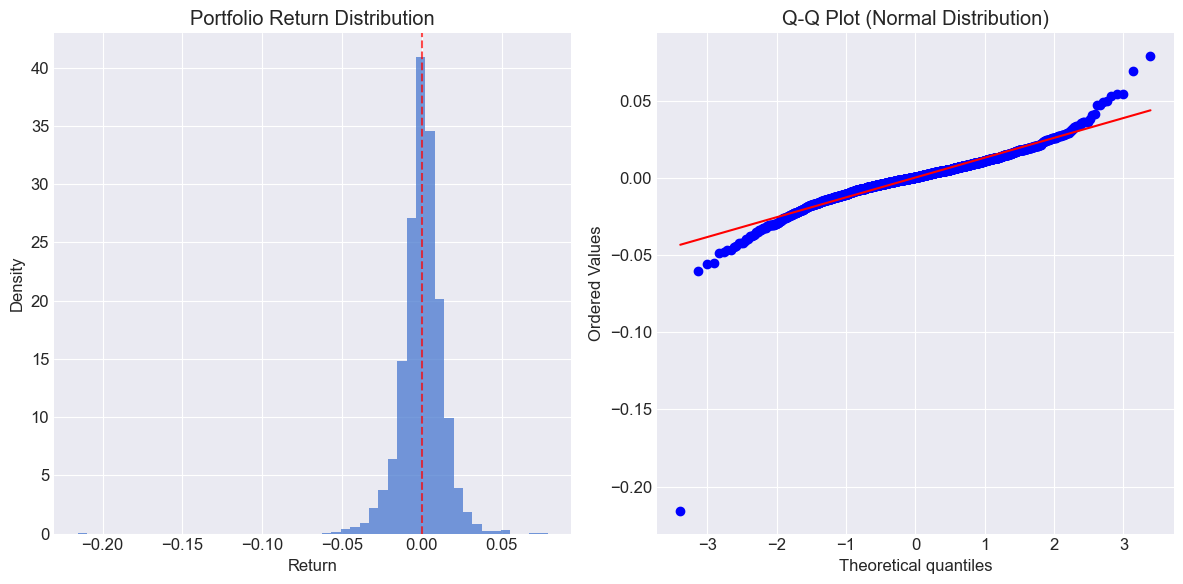

In [5]:
# Display portfolio return statistics
if portfolio_returns is not None:
    # Rename the dictionary to avoid conflict with scipy.stats
    return_stats = {
        'Mean': portfolio_returns.mean(),
        'Std Dev': portfolio_returns.std(),
        'Min': portfolio_returns.min(),
        'Max': portfolio_returns.max(),
        'Skewness': portfolio_returns.skew(),
        'Kurtosis': portfolio_returns.kurtosis(),
        'Annualized Return': portfolio_returns.mean() * 252,  # Assuming daily returns
        'Annualized Volatility': portfolio_returns.std() * np.sqrt(252)  # Assuming daily returns
    }
    
    # Create a DataFrame for better display
    stats_df = pd.DataFrame([return_stats])
    display(stats_df)
    
    # Plot return distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(portfolio_returns, bins=50, alpha=0.75, density=True)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Portfolio Return Distribution')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.grid(True)
    
    # Plot QQ-plot to check normality
    plt.subplot(1, 2, 2)
    from scipy import stats  # Use the scipy stats module
    stats.probplot(portfolio_returns, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normal Distribution)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 3. Calculate Investment Value

VaR is typically expressed in monetary terms. We'll convert our percentage returns to dollar amounts by assuming a specific investment value.

Investment value: $1,000,000
Mean daily return: $156.52
Standard deviation: $13,627.69
Minimum return: $-215,710.32
Maximum return: $78,838.29
Annualized return: $39,443.26


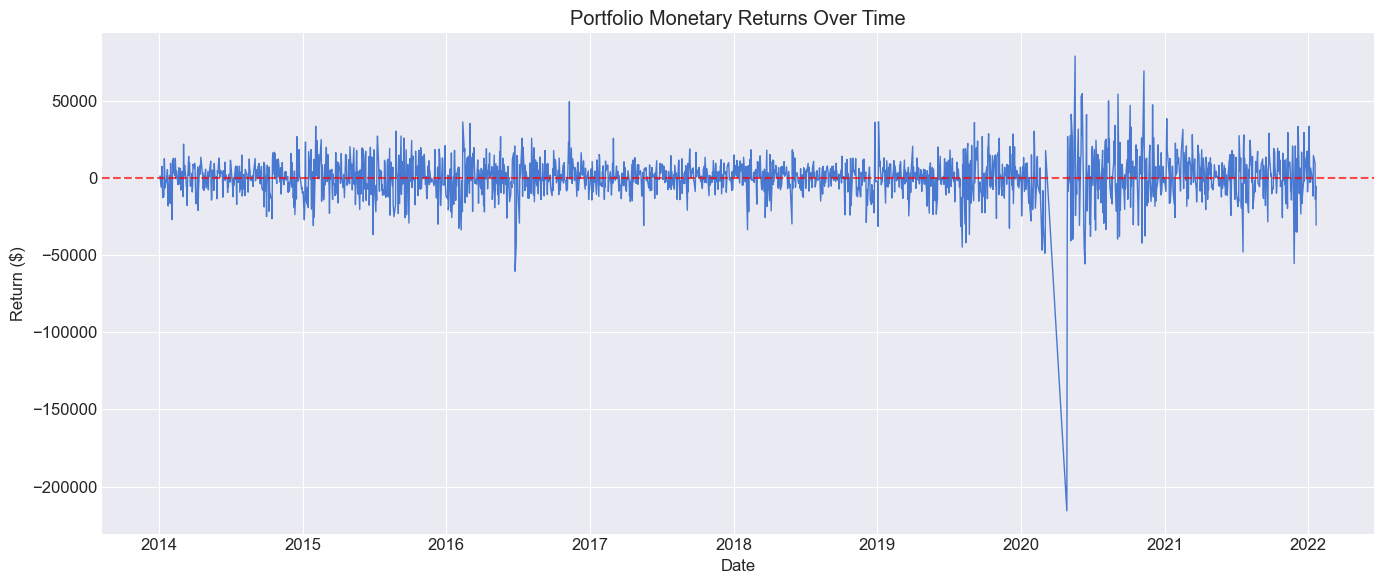

In [6]:
# Set the investment value
investment_value = 1000000  # $1 million

# Calculate monetary returns
if portfolio_returns is not None:
    monetary_returns = portfolio_returns * investment_value
    
    print(f"Investment value: ${investment_value:,}")
    print(f"Mean daily return: ${monetary_returns.mean():,.2f}")
    print(f"Standard deviation: ${monetary_returns.std():,.2f}")
    print(f"Minimum return: ${monetary_returns.min():,.2f}")
    print(f"Maximum return: ${monetary_returns.max():,.2f}")
    print(f"Annualized return: ${monetary_returns.mean() * 252:,.2f}")
    
    # Plot monetary returns over time
    plt.figure(figsize=(14, 6))
    plt.plot(monetary_returns.index, monetary_returns, linewidth=1)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Portfolio Monetary Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Return ($)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 4. Historical VaR Implementation

Historical VaR uses actual historical returns to estimate potential future losses. It makes no assumption about the distribution of returns.

In [7]:
# Calculate Historical VaR
if portfolio_returns is not None:
    # Set confidence level and lookback period
    confidence_level = var_config['historical']['default_confidence']
    lookback_days = var_config['historical']['lookback_days']
    
    # Calculate VaR
    hist_var = calculate_historical_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value,
        lookback_days=lookback_days
    )
    
    print(f"Historical VaR ({confidence_level*100}%) with {lookback_days} day lookback: ${hist_var:,.2f}")
    print(f"As a percentage of investment: {hist_var/investment_value:.2%}")
    
    # Calculate Conditional VaR (Expected Shortfall)
    hist_cvar = calculate_conditional_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    print(f"Historical Conditional VaR (Expected Shortfall): ${hist_cvar:,.2f}")
    print(f"As a percentage of investment: {hist_cvar/investment_value:.2%}")

Historical VaR (95.0%) with 252 day lookback: $19,950.64
As a percentage of investment: 2.00%
Historical Conditional VaR (Expected Shortfall): $32,051.35
As a percentage of investment: 3.21%


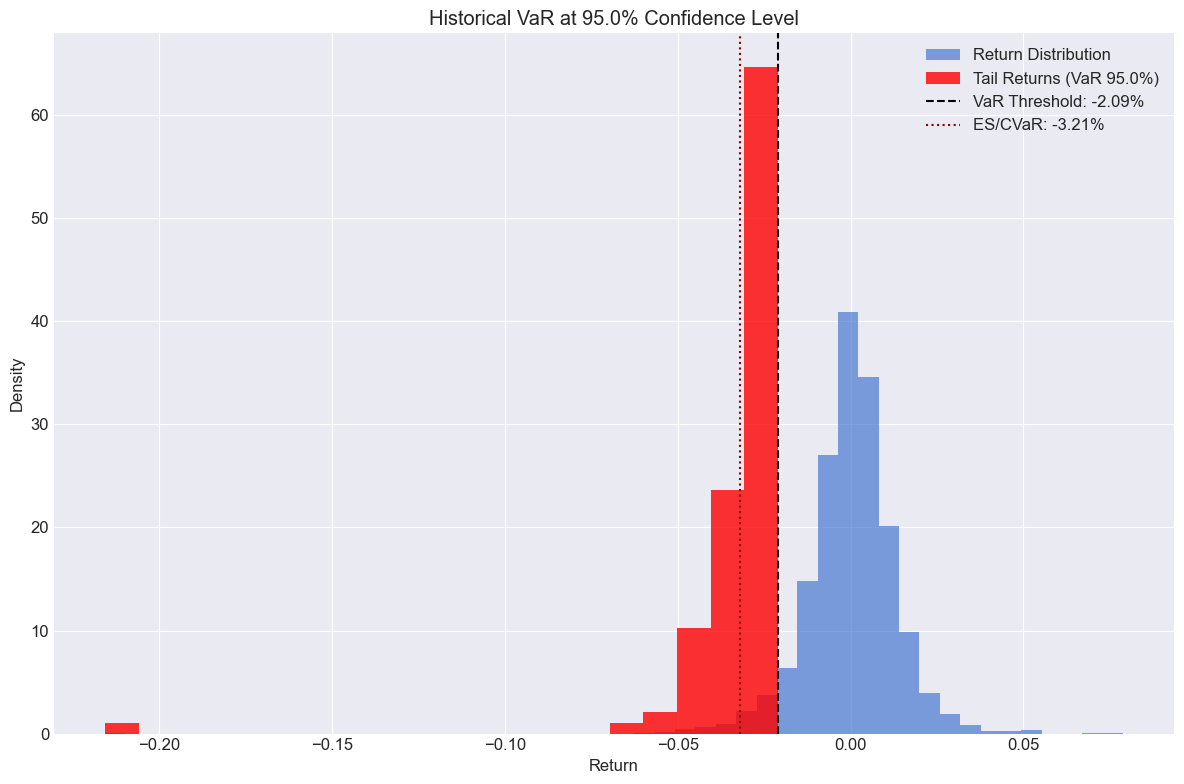

In [8]:
# Visualize Historical VaR on return distribution
if portfolio_returns is not None:
    # Calculate VaR returns (not in dollar terms)
    var_percentile = 1 - confidence_level
    hist_var_return = np.percentile(portfolio_returns, var_percentile * 100)
    
    # Calculate all returns below VaR threshold
    tail_returns = portfolio_returns[portfolio_returns <= hist_var_return]
    
    # Plot return distribution with VaR
    plt.figure(figsize=(12, 8))
    
    # Plot all returns histogram
    plt.hist(portfolio_returns, bins=50, alpha=0.7, density=True, label='Return Distribution')
    
    # Plot tail returns in a different color
    plt.hist(tail_returns, bins=20, alpha=0.8, density=True, color='red', label=f'Tail Returns (VaR {confidence_level*100}%)')
    
    # Add VaR line
    plt.axvline(x=hist_var_return, color='black', linestyle='--', label=f'VaR Threshold: {hist_var_return:.2%}')
    
    # Add Expected Shortfall (CVaR) line
    plt.axvline(x=tail_returns.mean(), color='darkred', linestyle=':', label=f'ES/CVaR: {tail_returns.mean():.2%}')
    
    plt.title(f'Historical VaR at {confidence_level*100}% Confidence Level')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Historical VaR at Different Confidence Levels:


,confidence_level,var_value,cvar_value,var_pct,cvar_pct,cvar_var_ratio
0,0.90,14242.783365,24568.657349,1.424278,2.456866,1.724990
1,0.95,20927.920178,32051.348780,2.092792,3.205135,1.531511
2,0.99,36697.148433,53241.439538,3.669715,5.324144,1.450833


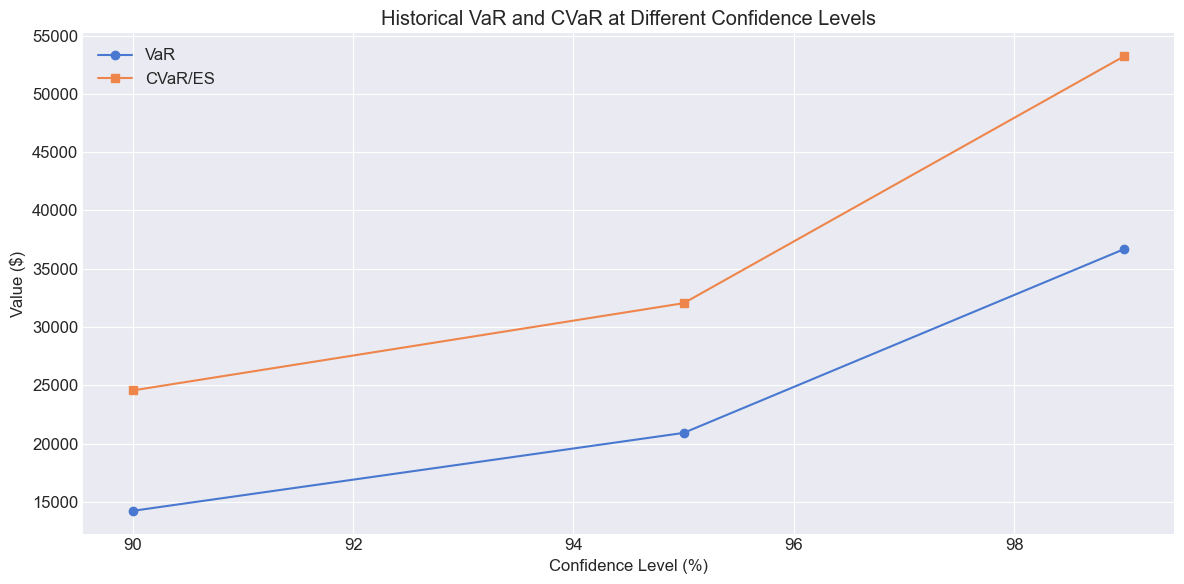

In [9]:
# Calculate Historical VaR for multiple confidence levels
if portfolio_returns is not None:
    # Calculate VaR for different confidence levels
    confidence_levels = var_config['historical']['confidence_levels']
    
    var_results = calculate_var_by_confidence(
        returns=portfolio_returns,
        confidence_levels=confidence_levels,
        investment_value=investment_value
    )
    
    # Display results
    print("Historical VaR at Different Confidence Levels:")
    display(var_results)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Plot VaR
    plt.plot(var_results['confidence_level'] * 100, var_results['var_value'], 'o-', label='VaR')
    
    # Plot CVaR
    plt.plot(var_results['confidence_level'] * 100, var_results['cvar_value'], 's-', label='CVaR/ES')
    
    plt.title('Historical VaR and CVaR at Different Confidence Levels')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5. Parametric VaR Implementation

Parametric VaR assumes that returns follow a normal (or other parametric) distribution. It uses the mean and volatility to estimate VaR.

In [10]:
# Calculate Parametric VaR (normal distribution)
if portfolio_returns is not None:
    # Set confidence level
    confidence_level = var_config['historical']['default_confidence']
    
    # Calculate Parametric VaR
    param_var = calculate_parametric_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    print(f"Parametric VaR ({confidence_level*100}%): ${param_var:,.2f}")
    print(f"As a percentage of investment: {param_var/investment_value:.2%}")
    
    # Calculate Parametric Expected Shortfall
    param_es = calculate_parametric_expected_shortfall(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    print(f"Parametric Expected Shortfall (ES): ${param_es:,.2f}")
    print(f"As a percentage of investment: {param_es/investment_value:.2%}")
    
    # Calculate VaR confidence interval
    var_ci = var_confidence_interval(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value,
        alpha=0.05  # 95% confidence interval for the VaR estimate
    )
    
    print(f"\nVaR 95% Confidence Interval: ${var_ci[0]:,.2f} to ${var_ci[1]:,.2f}")

Parametric VaR (95.0%): $22,259.04
As a percentage of investment: 2.23%
Parametric Expected Shortfall (ES): $27,953.50
As a percentage of investment: 2.80%

VaR 95% Confidence Interval: $11,439.16 to $215,710.32


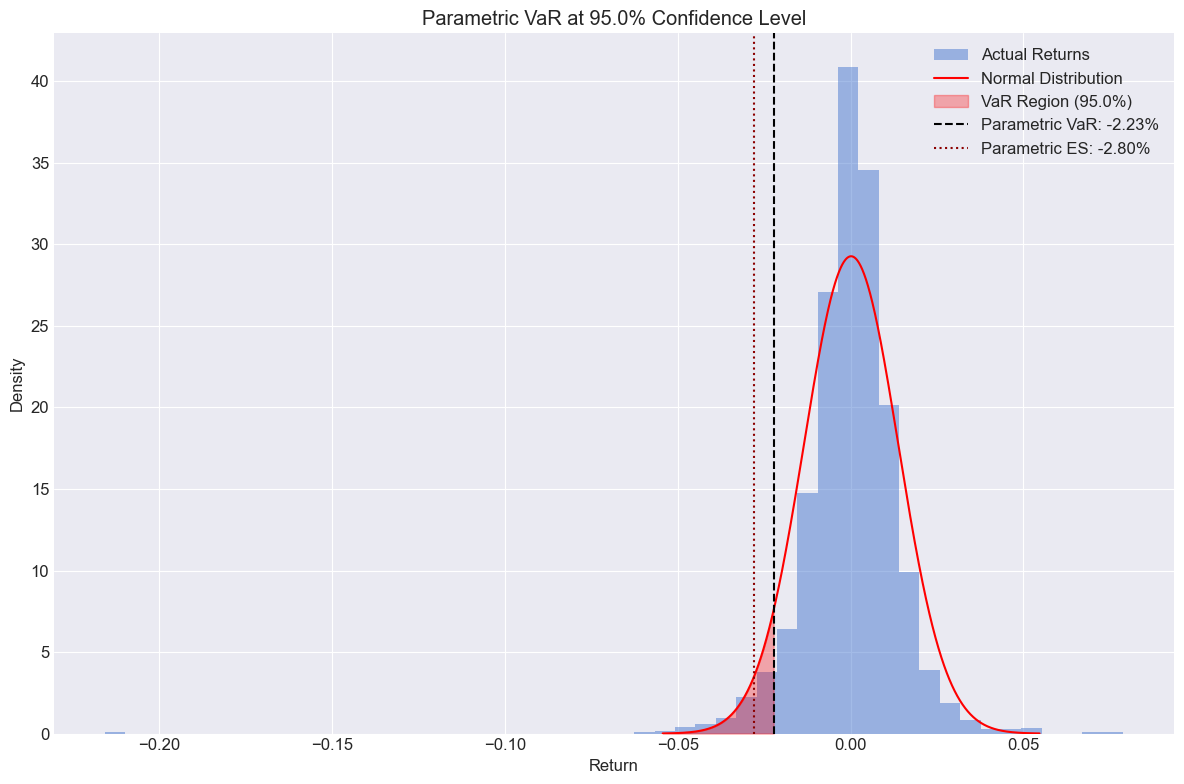

In [11]:
# Visualize Parametric VaR
if portfolio_returns is not None:
    # Get mean and std of returns
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    
    # Calculate VaR in return space
    z_score = stats.norm.ppf(1 - confidence_level)
    param_var_return = mu + z_score * sigma
    
    # Calculate ES in return space
    param_es_return = mu - sigma * stats.norm.pdf(stats.norm.ppf(1 - confidence_level)) / (1 - confidence_level)
    
    # Generate x values for plotting the normal distribution
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    y = stats.norm.pdf(x, mu, sigma)
    
    # Plot return distribution with normal overlay and VaR
    plt.figure(figsize=(12, 8))
    
    # Plot histogram of actual returns
    plt.hist(portfolio_returns, bins=50, alpha=0.5, density=True, label='Actual Returns')
    
    # Plot normal distribution
    plt.plot(x, y, 'r-', label='Normal Distribution')
    
    # Shade the tail beyond VaR
    x_tail = x[x <= param_var_return]
    y_tail = y[x <= param_var_return]
    plt.fill_between(x_tail, y_tail, alpha=0.3, color='red', label=f'VaR Region ({confidence_level*100}%)')
    
    # Add VaR line
    plt.axvline(x=param_var_return, color='black', linestyle='--', label=f'Parametric VaR: {param_var_return:.2%}')
    
    # Add ES line
    plt.axvline(x=param_es_return, color='darkred', linestyle=':', label=f'Parametric ES: {param_es_return:.2%}')
    
    plt.title(f'Parametric VaR at {confidence_level*100}% Confidence Level')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Parametric VaR at Different Confidence Levels:


,confidence_level,var_value,es_value
0,0.90,17308.071937,23759.855085
1,0.95,22259.041319,27953.498436
2,0.99,31546.236494,36164.203424


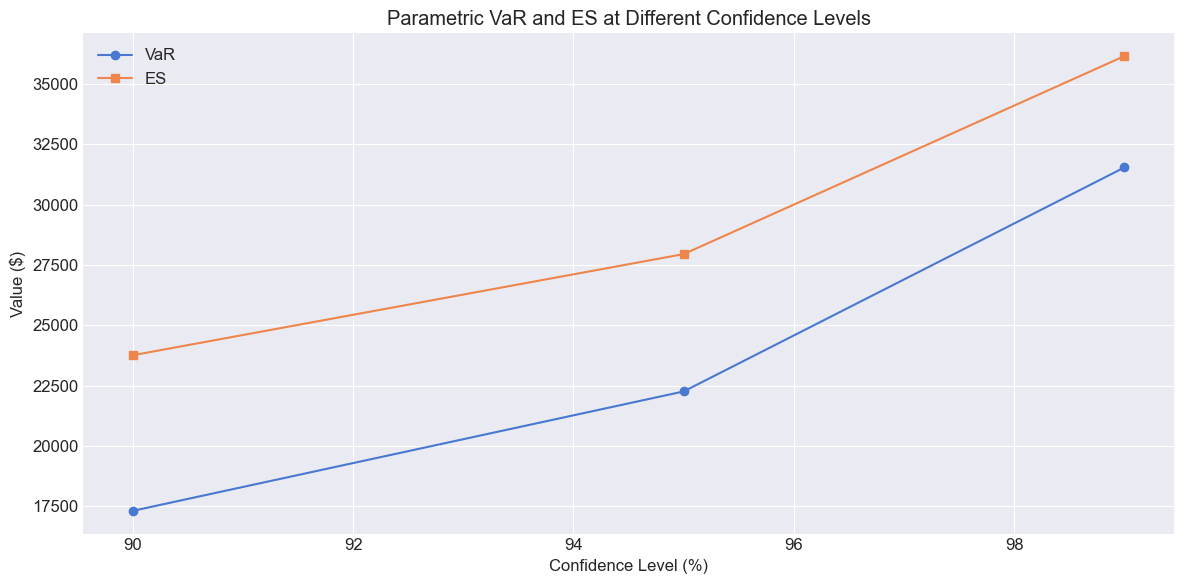

In [12]:
# Calculate Parametric VaR for multiple confidence levels
if portfolio_returns is not None:
    # Set confidence levels
    confidence_levels = var_config['parametric']['confidence_levels'] if 'parametric' in var_config else [0.90, 0.95, 0.99]
    
    # Calculate VaR and ES for each confidence level
    param_results = []
    
    for conf_level in confidence_levels:
        var_value = calculate_parametric_var(
            returns=portfolio_returns,
            confidence_level=conf_level,
            investment_value=investment_value
        )
        
        es_value = calculate_parametric_expected_shortfall(
            returns=portfolio_returns,
            confidence_level=conf_level,
            investment_value=investment_value
        )
        
        param_results.append({
            'confidence_level': conf_level,
            'var_value': var_value,
            'es_value': es_value
        })
    
    # Convert to DataFrame
    param_results_df = pd.DataFrame(param_results)
    
    # Display results
    print("Parametric VaR at Different Confidence Levels:")
    display(param_results_df)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Plot VaR
    plt.plot(param_results_df['confidence_level'] * 100, param_results_df['var_value'], 'o-', label='VaR')
    
    # Plot ES
    plt.plot(param_results_df['confidence_level'] * 100, param_results_df['es_value'], 's-', label='ES')
    
    plt.title('Parametric VaR and ES at Different Confidence Levels')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 6. Expected Shortfall (ES) Implementation

Expected Shortfall measures the average loss beyond VaR. It provides a more comprehensive view of tail risk.

In [13]:
# Calculate and compare Expected Shortfall using different methods
if portfolio_returns is not None:
    # Set confidence level
    confidence_level = 0.95
    
    # Calculate ES using different methods
    es_results = compare_var_and_es(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    # Display results
    print(f"VaR and ES Comparison at {confidence_level*100}% Confidence Level:")
    display(es_results)

VaR and ES Comparison at 95.0% Confidence Level:


,Method,VaR,ES,ES/VaR Ratio,VaR %,ES %
0,Historical,20927.920178,32051.348780,1.531511,2.092792,3.205135
1,Parametric,22259.041319,27953.498436,1.255827,2.225904,2.795350


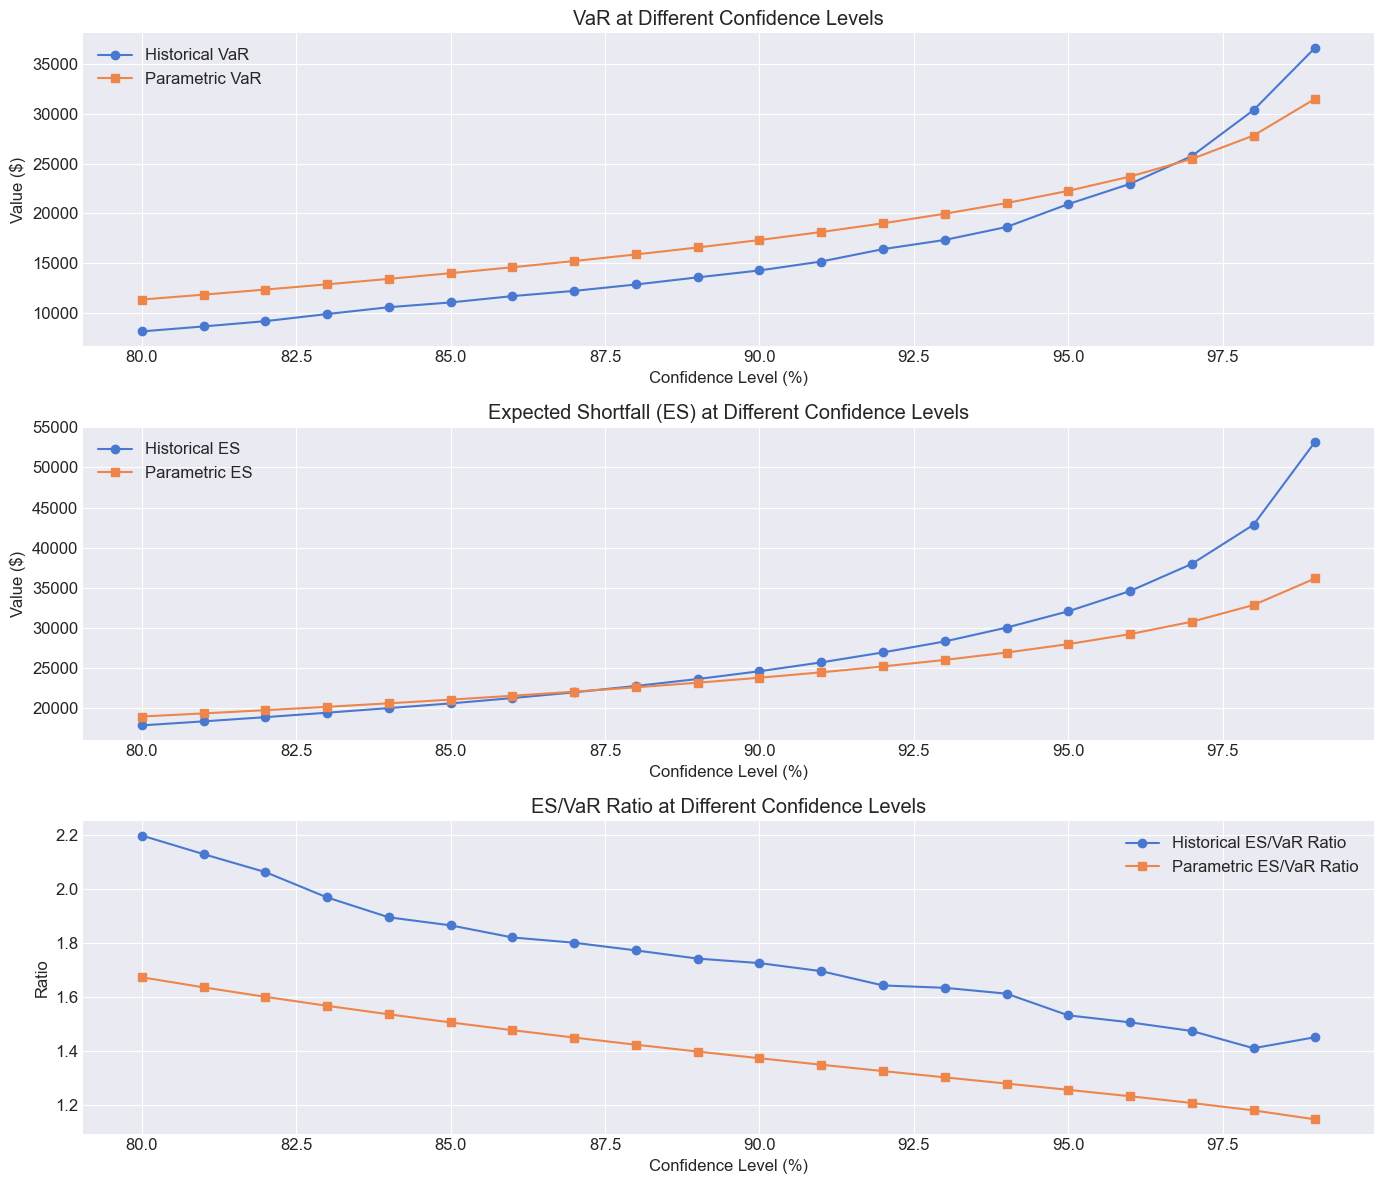

In [14]:
# Visualize ES across different confidence levels
if portfolio_returns is not None and 'es_results' in locals():
    # Set up confidence levels to evaluate
    confidence_range = np.linspace(0.8, 0.99, 20)
    
    # Calculate VaR and ES for each confidence level
    results = []
    
    for conf in confidence_range:
        # Historical VaR and ES
        hist_var = calculate_historical_var(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        hist_es = calculate_conditional_var(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        # Parametric VaR and ES
        param_var = calculate_parametric_var(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        param_es = calculate_parametric_expected_shortfall(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        results.append({
            'confidence_level': conf,
            'historical_var': hist_var,
            'historical_es': hist_es,
            'parametric_var': param_var,
            'parametric_es': param_es
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate ES/VaR ratios
    results_df['historical_ratio'] = results_df['historical_es'] / results_df['historical_var']
    results_df['parametric_ratio'] = results_df['parametric_es'] / results_df['parametric_var']
    
    # Plot VaR and ES by confidence level
    plt.figure(figsize=(14, 12))
    
    # Plot VaR values
    plt.subplot(3, 1, 1)
    plt.plot(results_df['confidence_level'] * 100, results_df['historical_var'], 'o-', label='Historical VaR')
    plt.plot(results_df['confidence_level'] * 100, results_df['parametric_var'], 's-', label='Parametric VaR')
    plt.title('VaR at Different Confidence Levels')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    
    # Plot ES values
    plt.subplot(3, 1, 2)
    plt.plot(results_df['confidence_level'] * 100, results_df['historical_es'], 'o-', label='Historical ES')
    plt.plot(results_df['confidence_level'] * 100, results_df['parametric_es'], 's-', label='Parametric ES')
    plt.title('Expected Shortfall (ES) at Different Confidence Levels')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    
    # Plot ES/VaR ratio
    plt.subplot(3, 1, 3)
    plt.plot(results_df['confidence_level'] * 100, results_df['historical_ratio'], 'o-', label='Historical ES/VaR Ratio')
    plt.plot(results_df['confidence_level'] * 100, results_df['parametric_ratio'], 's-', label='Parametric ES/VaR Ratio')
    plt.title('ES/VaR Ratio at Different Confidence Levels')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Ratio')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## 7. Compare VaR Methodologies

In [15]:
# Create a comprehensive comparison of VaR methodologies
if portfolio_returns is not None:
    # Define confidence levels to compare
    confidence_levels = [0.90, 0.95, 0.99]
    
    # Create a comparison DataFrame
    comparison_data = []
    
    for conf in confidence_levels:
        # Historical VaR
        hist_var = calculate_historical_var(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        # Historical ES
        hist_es = calculate_conditional_var(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        # Parametric VaR
        param_var = calculate_parametric_var(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        # Parametric ES
        param_es = calculate_parametric_expected_shortfall(
            returns=portfolio_returns,
            confidence_level=conf,
            investment_value=investment_value
        )
        
        comparison_data.append({
            'confidence_level': conf,
            'historical_var': hist_var,
            'historical_es': hist_es,
            'parametric_var': param_var,
            'parametric_es': param_es,
            'var_difference': hist_var - param_var,
            'var_difference_pct': (hist_var - param_var) / param_var * 100,
            'es_difference': hist_es - param_es,
            'es_difference_pct': (hist_es - param_es) / param_es * 100,
            'historical_ratio': hist_es / hist_var,
            'parametric_ratio': param_es / param_var
        })
    
    # Convert to DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display comparison
    print("Comparison of VaR Methodologies:")
    display(comparison_df)
    
    # Save comparison results
    comparison_file = RESULTS_DIR / "var_comparison.csv"
    comparison_df.to_csv(comparison_file, index=False)
    print(f"Comparison saved to {comparison_file}")

Comparison of VaR Methodologies:


,confidence_level,historical_var,historical_es,parametric_var,parametric_es,var_difference,var_difference_pct,es_difference,es_difference_pct,historical_ratio,parametric_ratio
0,0.90,14242.783365,24568.657349,17308.071937,23759.855085,-3065.288571,-17.710168,808.802264,3.404071,1.724990,1.372762
1,0.95,20927.920178,32051.348780,22259.041319,27953.498436,-1331.121141,-5.980137,4097.850344,14.659526,1.531511,1.255827
2,0.99,36697.148433,53241.439538,31546.236494,36164.203424,5150.911939,16.328135,17077.236113,47.221381,1.450833,1.146387


Comparison saved to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/var_comparison.csv


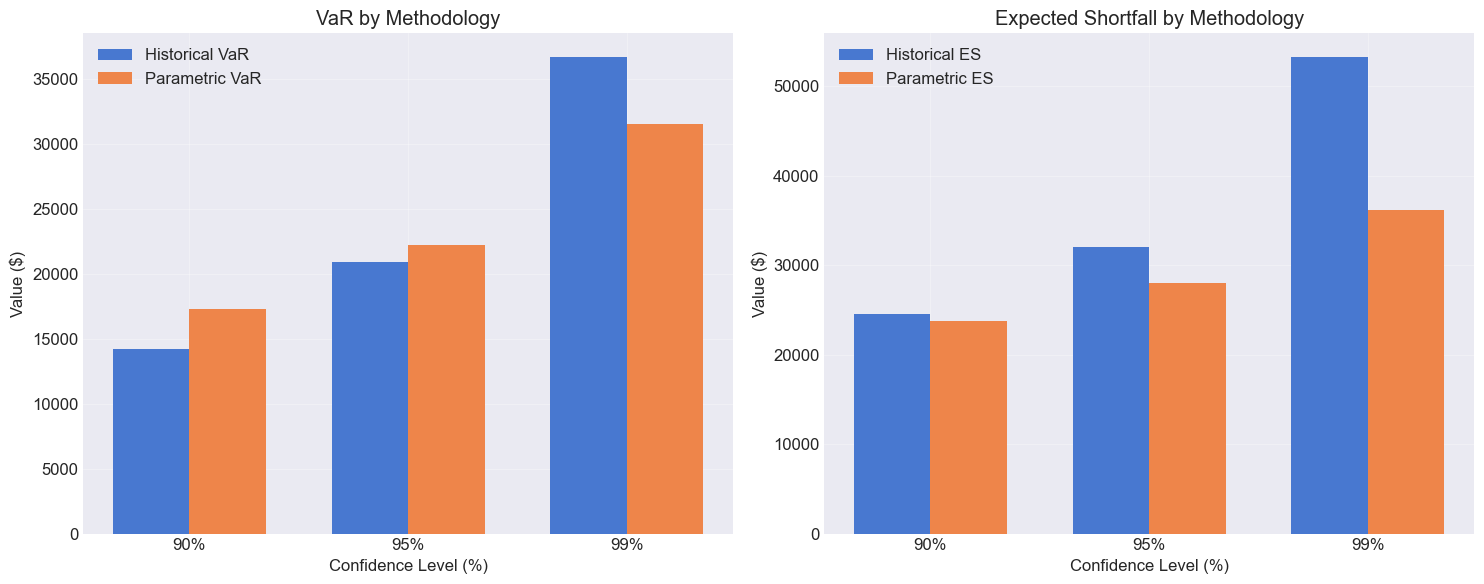

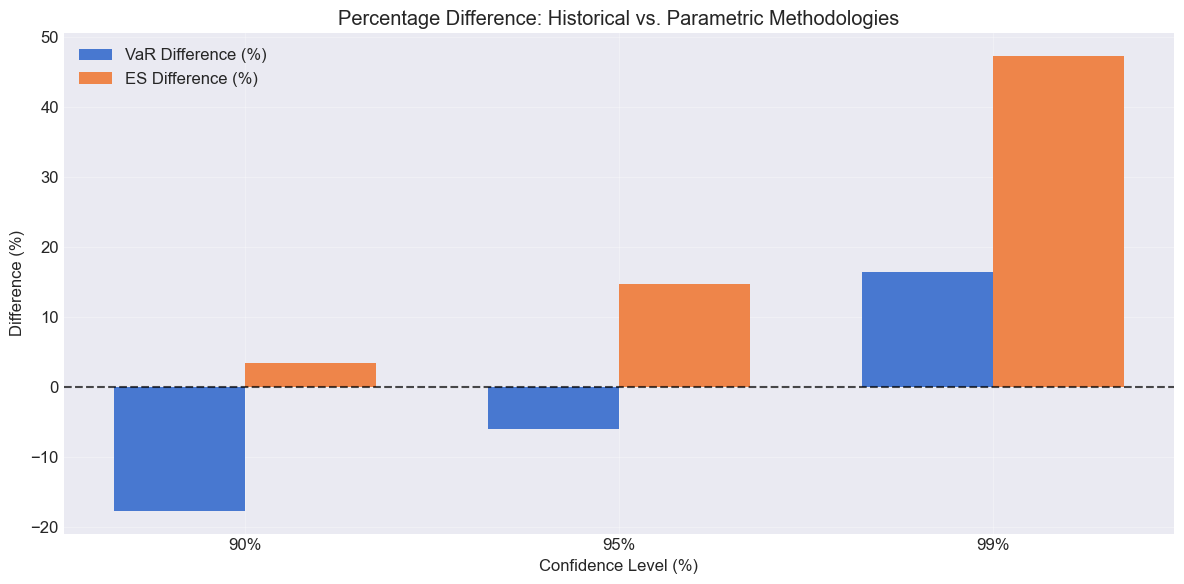

In [16]:
# Visualize VaR comparison
if 'comparison_df' in locals():
    # Create a grouped bar chart comparing VaR values
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prepare data for plotting
    conf_levels = comparison_df['confidence_level'] * 100
    x = np.arange(len(conf_levels))
    width = 0.35
    
    # Plot VaR comparison
    axes[0].bar(x - width/2, comparison_df['historical_var'], width, label='Historical VaR')
    axes[0].bar(x + width/2, comparison_df['parametric_var'], width, label='Parametric VaR')
    axes[0].set_title('VaR by Methodology')
    axes[0].set_xlabel('Confidence Level (%)')
    axes[0].set_ylabel('Value ($)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f"{cl:.0f}%" for cl in conf_levels])
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot ES comparison
    axes[1].bar(x - width/2, comparison_df['historical_es'], width, label='Historical ES')
    axes[1].bar(x + width/2, comparison_df['parametric_es'], width, label='Parametric ES')
    axes[1].set_title('Expected Shortfall by Methodology')
    axes[1].set_xlabel('Confidence Level (%)')
    axes[1].set_ylabel('Value ($)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f"{cl:.0f}%" for cl in conf_levels])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a chart showing the differences between methodologies
    plt.figure(figsize=(12, 6))
    
    plt.bar(x - width/2, comparison_df['var_difference_pct'], width, label='VaR Difference (%)')
    plt.bar(x + width/2, comparison_df['es_difference_pct'], width, label='ES Difference (%)')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.title('Percentage Difference: Historical vs. Parametric Methodologies')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Difference (%)')
    plt.xticks(x, [f"{cl:.0f}%" for cl in conf_levels])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Visualize VaR on Portfolio Returns

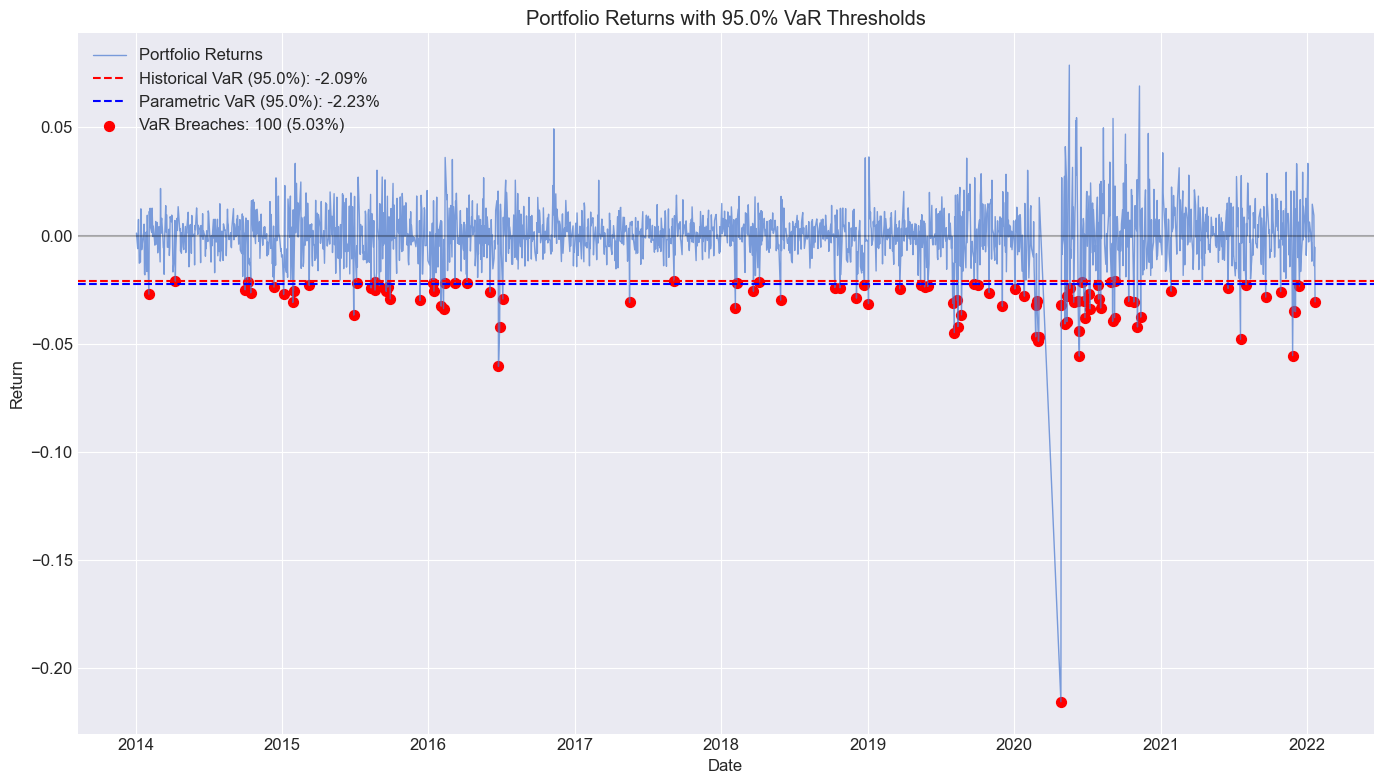

In [17]:
# Plot portfolio returns with VaR thresholds
if portfolio_returns is not None:
    # Set confidence level
    confidence_level = 0.95
    
    # Calculate VaR in return terms
    hist_var_return = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    # Calculate parametric VaR in return terms
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    z_score = stats.norm.ppf(1 - confidence_level)
    param_var_return = mu + z_score * sigma
    
    # Plot portfolio returns with VaR lines
    plt.figure(figsize=(14, 8))
    
    # Plot portfolio returns
    plt.plot(portfolio_returns.index, portfolio_returns, linewidth=1, alpha=0.7, label='Portfolio Returns')
    
    # Add horizontal lines for VaR thresholds
    plt.axhline(y=hist_var_return, color='red', linestyle='--', label=f'Historical VaR ({confidence_level*100}%): {hist_var_return:.2%}')
    plt.axhline(y=param_var_return, color='blue', linestyle='--', label=f'Parametric VaR ({confidence_level*100}%): {param_var_return:.2%}')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Highlight VaR breaches for historical VaR
    breaches = portfolio_returns[portfolio_returns < hist_var_return]
    plt.scatter(breaches.index, breaches, color='red', s=50, label=f'VaR Breaches: {len(breaches)} ({len(breaches)/len(portfolio_returns):.2%})')
    
    plt.title(f'Portfolio Returns with {confidence_level*100}% VaR Thresholds')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

VaR Breach Analysis at 95.0% Confidence Level:
Expected breach rate: 5.00%
Historical VaR breaches: 100 (5.03%)
Parametric VaR breaches: 86 (4.33%)

Largest Historical VaR Breaches:


Date
2020-04-27   -0.215710
2016-06-24   -0.060556
2020-06-12   -0.055767
2021-11-26   -0.055531
2020-03-02   -0.048858
2021-07-19   -0.047999
2020-02-24   -0.046867
2020-03-03   -0.046863
2019-08-05   -0.044889
2020-06-10   -0.044323
Name: 0, dtype: float64


Consecutive VaR Breach Run Analysis:
Number of breach runs: 91
Maximum consecutive breaches: 3
Average run length: 1.10 days


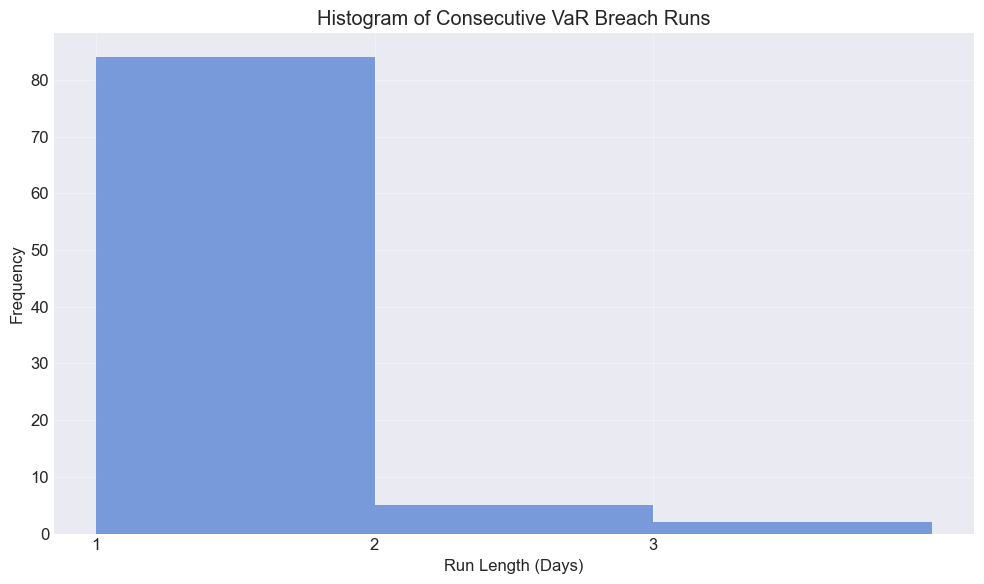

In [18]:
# Analyze VaR breaches
if portfolio_returns is not None:
    # Set confidence level
    confidence_level = 0.95
    
    # Calculate VaR in return terms
    hist_var_return = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    # Calculate parametric VaR in return terms
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    z_score = stats.norm.ppf(1 - confidence_level)
    param_var_return = mu + z_score * sigma
    
    # Identify breaches
    hist_breaches = portfolio_returns[portfolio_returns < hist_var_return]
    param_breaches = portfolio_returns[portfolio_returns < param_var_return]
    
    # Calculate breach statistics
    hist_breach_pct = len(hist_breaches) / len(portfolio_returns) * 100
    param_breach_pct = len(param_breaches) / len(portfolio_returns) * 100
    expected_breach_pct = (1 - confidence_level) * 100
    
    print(f"VaR Breach Analysis at {confidence_level*100}% Confidence Level:")
    print(f"Expected breach rate: {expected_breach_pct:.2f}%")
    print(f"Historical VaR breaches: {len(hist_breaches)} ({hist_breach_pct:.2f}%)")
    print(f"Parametric VaR breaches: {len(param_breaches)} ({param_breach_pct:.2f}%)")
    
    # Show the largest breaches
    print("\nLargest Historical VaR Breaches:")
    display(hist_breaches.sort_values().head(10))
    
    # Analyze breach clustering (consecutive breaches)
    hist_breach_days = pd.Series(index=portfolio_returns.index, data=portfolio_returns < hist_var_return)
    
    # Calculate runs of consecutive breaches
    runs = []
    current_run = 0
    
    for day, is_breach in hist_breach_days.items():
        if is_breach:
            current_run += 1
        elif current_run > 0:
            runs.append(current_run)
            current_run = 0
    
    # Add the last run if it exists
    if current_run > 0:
        runs.append(current_run)
    
    # Display breach run statistics
    if runs:
        print(f"\nConsecutive VaR Breach Run Analysis:")
        print(f"Number of breach runs: {len(runs)}")
        print(f"Maximum consecutive breaches: {max(runs)}")
        print(f"Average run length: {np.mean(runs):.2f} days")
        
        # Plot histogram of runs
        plt.figure(figsize=(10, 6))
        plt.hist(runs, bins=range(1, max(runs) + 2), alpha=0.7)
        plt.title('Histogram of Consecutive VaR Breach Runs')
        plt.xlabel('Run Length (Days)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.xticks(range(1, max(runs) + 1))
        plt.tight_layout()
        plt.show()

## 9. Save VaR Results for the Dashboard

In [19]:
# Calculate and save VaR results for the dashboard
if portfolio_returns is not None:
    # Define confidence levels
    confidence_levels = [0.90, 0.95, 0.99]
    
    # Define time horizons (in days)
    time_horizons = [1, 5, 10, 20]
    
    # Calculate VaR for different methodologies, confidence levels, and time horizons
    var_results = []
    
    for confidence in confidence_levels:
        for horizon in time_horizons:
            # Scale factors for time horizons (simplistic approach, assumes i.i.d returns)
            time_factor = np.sqrt(horizon)
            
            # Calculate Historical VaR
            hist_var = calculate_historical_var(
                returns=portfolio_returns,
                confidence_level=confidence,
                investment_value=investment_value
            )
            
            # Scale for time horizon
            hist_var_scaled = hist_var * time_factor
            
            # Calculate Historical ES
            hist_es = calculate_conditional_var(
                returns=portfolio_returns,
                confidence_level=confidence,
                investment_value=investment_value
            )
            
            # Scale for time horizon
            hist_es_scaled = hist_es * time_factor
            
            # Calculate Parametric VaR
            param_var = calculate_parametric_var(
                returns=portfolio_returns,
                confidence_level=confidence,
                investment_value=investment_value
            )
            
            # Scale for time horizon
            param_var_scaled = param_var * time_factor
            
            # Calculate Parametric ES
            param_es = calculate_parametric_expected_shortfall(
                returns=portfolio_returns,
                confidence_level=confidence,
                investment_value=investment_value
            )
            
            # Scale for time horizon
            param_es_scaled = param_es * time_factor
            
            # Add to results
            var_results.append({
                'confidence_level': confidence,
                'time_horizon': horizon,
                'historical_var': hist_var_scaled,
                'historical_es': hist_es_scaled,
                'parametric_var': param_var_scaled,
                'parametric_es': param_es_scaled,
                'historical_pct': hist_var_scaled / investment_value * 100,
                'parametric_pct': param_var_scaled / investment_value * 100
            })
    
    # Convert to DataFrame
    var_results_df = pd.DataFrame(var_results)
    
    # Display results
    print("VaR Results for Dashboard:")
    display(var_results_df)
    
    # Save results
    results_file = RESULTS_DIR / "var_results.csv"
    var_results_df.to_csv(results_file, index=False)
    print(f"VaR results saved to {results_file}")

VaR Results for Dashboard:


,confidence_level,time_horizon,historical_var,historical_es,parametric_var,parametric_es,historical_pct,parametric_pct
0,0.90,1,14242.783365,24568.657349,17308.071937,23759.855085,1.424278,1.730807
1,0.90,5,31847.831794,54937.187948,38702.025410,53128.651106,3.184783,3.870203
2,0.90,10,45039.635655,77692.916275,54732.929226,75135.258945,4.503964,5.473293
3,0.90,20,63695.663588,109874.375896,77404.050819,106257.302213,6.369566,7.740405
4,0.95,1,20927.920178,32051.348780,22259.041319,27953.498436,2.092792,2.225904
5,0.95,5,46796.252145,71668.994642,49772.729504,62505.922712,4.679625,4.977273
6,0.95,10,66179.894452,101355.264224,70389.269100,88396.723628,6.617989,7.038927
7,0.95,20,93592.504290,143337.989284,99545.459007,125011.845424,9.359250,9.954546
8,0.99,1,36697.148433,53241.439538,31546.236494,36164.203424,3.669715,3.154624
9,0.99,5,82057.318478,119051.478026,70539.529235,80865.617209,8.205732,7.053953


VaR results saved to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/var_results.csv


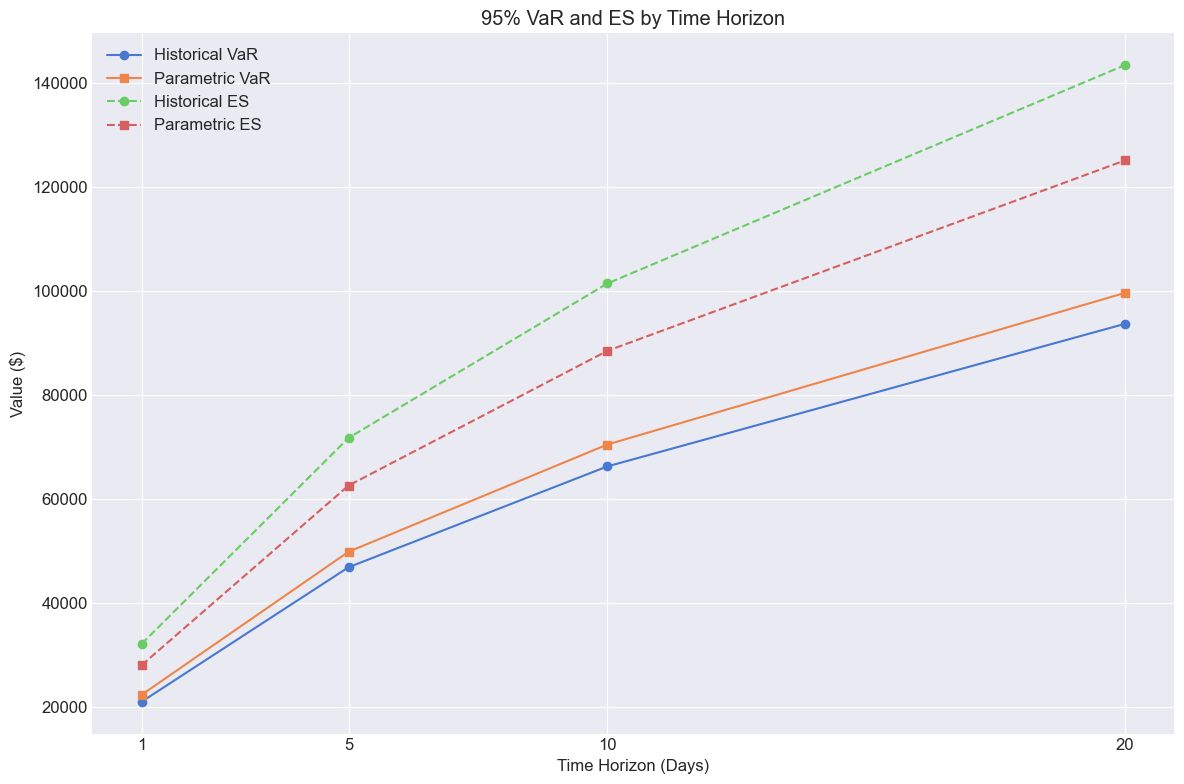

In [20]:
# Visualize VaR by time horizon
if 'var_results_df' in locals():
    # Filter to 95% confidence level
    results_95 = var_results_df[var_results_df['confidence_level'] == 0.95]
    
    # Plot VaR by time horizon
    plt.figure(figsize=(12, 8))
    
    # Plot historical and parametric VaR
    plt.plot(results_95['time_horizon'], results_95['historical_var'], 'o-', label='Historical VaR')
    plt.plot(results_95['time_horizon'], results_95['parametric_var'], 's-', label='Parametric VaR')
    
    # Plot historical and parametric ES
    plt.plot(results_95['time_horizon'], results_95['historical_es'], 'o--', label='Historical ES')
    plt.plot(results_95['time_horizon'], results_95['parametric_es'], 's--', label='Parametric ES')
    
    plt.title('95% VaR and ES by Time Horizon')
    plt.xlabel('Time Horizon (Days)')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    plt.xticks(results_95['time_horizon'])
    plt.tight_layout()
    plt.show()

## 10. Summary and Analysis

### Key Findings from VaR Analysis

We've implemented and compared several VaR methodologies for our portfolio risk analysis:

1. **Historical VaR**: Uses actual historical returns distribution without assumptions about the shape of the distribution
   - Pros: Captures actual historical tail events, no distribution assumptions
   - Cons: Limited by the historical record, may not capture future extreme events

2. **Parametric VaR**: Assumes returns follow a normal distribution
   - Pros: Simple to implement, requires less historical data
   - Cons: Assumes normality, which may underestimate tail risk

3. **Expected Shortfall (ES)**: Measures the average loss beyond VaR
   - Pros: Provides a more comprehensive view of tail risk, addresses VaR's weaknesses
   - Cons: More sensitive to extreme outliers

### Observations

- The QQ plot shows that our portfolio returns exhibit fat tails compared to a normal distribution, which is typical for financial returns.
- Historical VaR tends to be higher than Parametric VaR at higher confidence levels, reflecting the fat tails in the actual return distribution.
- Expected Shortfall provides a more conservative risk measure, especially at higher confidence levels.
- VaR increases with time horizon, following approximately a square root of time rule.

### Next Steps

1. Proceed to Monte Carlo simulations for more sophisticated risk analysis (04_monte_carlo_sim.ipynb)
2. Develop stress testing scenarios to assess portfolio performance under extreme conditions (05_stress_testing.ipynb)
3. Validate our VaR models through backtesting (06_backtesting.ipynb)

## Conclusion

This notebook has demonstrated the implementation and comparison of various VaR methodologies for portfolio risk management. By calculating Historical VaR, Parametric VaR, and Expected Shortfall, we have gained insights into the potential risks associated with our portfolio under different scenarios.

The results highlight the importance of using multiple risk measures to capture different aspects of portfolio risk. Historical VaR provides a data-driven approach, while Parametric VaR offers simplicity and efficiency. Expected Shortfall complements these measures by focusing on the tail risk beyond VaR.

The next steps involve further refining our risk models through Monte Carlo simulations, stress testing, and backtesting to ensure robust risk management practices.